# Neural Networks — Vehicle Loan Default (Part 1: Data Prep)



This notebook is the neural-network side of the project.



**In this step (Part 1), we only:**

- Load the shared processed dataset: `data/processed/loan_processed.csv`

- Load (or create) the shared split file: `data/splits/split_uniqueid.csv`

- Create `train/val/test` DataFrames using that split

- Define leak-safe preprocessing for NN models (fit on train only):

  - numeric: impute + standardize

  - categorical: impute + encode (one-hot baseline)



In [2]:
import os

import re

from dataclasses import dataclass



import numpy as np

import pandas as pd



from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.metrics import (

    roc_auc_score,

    precision_score,

    recall_score,

    f1_score,

    confusion_matrix,

    roc_curve,

    precision_recall_curve,
    average_precision_score


)

from sklearn.model_selection import StratifiedShuffleSplit

# TensorFlow / Keras for neural networks
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers



from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder



import matplotlib.pyplot as plt



RANDOM_STATE = 42



# Shared artifacts created by notebooks/preprocessing.ipynb

DATA_PATH = os.path.join('..', 'data', 'processed', 'loan_processed.csv')

SPLIT_PATH = os.path.join('..', 'data', 'splits', 'split_uniqueid.csv')



RESULTS_DIR = os.path.join('..', 'results')

MODELS_DIR = os.path.join('..', 'models')



os.makedirs(os.path.dirname(SPLIT_PATH), exist_ok=True)

os.makedirs(RESULTS_DIR, exist_ok=True)

os.makedirs(MODELS_DIR, exist_ok=True)


c:\Users\HP\Desktop\QF Masters\Sem-3\ML in Finanace 2\Project\Boosting-Models-vs-Neural-networks-for-Credit-risk-\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
if not os.path.exists(DATA_PATH):

    raise FileNotFoundError(

        f"Missing {DATA_PATH}. Run notebooks/preprocessing.ipynb to generate data/processed/loan_processed.csv"

    )



df = pd.read_csv(DATA_PATH)

print('Loaded processed CSV:', df.shape)

display(df.head())



target_col = 'LOAN_DEFAULT'

id_col = 'UNIQUEID'



missing = [c for c in [id_col, target_col] if c not in df.columns]

if missing:

    raise ValueError(f"Processed CSV missing required columns: {missing}")



print('Target distribution:')

display(df[target_col].value_counts(dropna=False))

display(df[target_col].value_counts(normalize=True, dropna=False))


Loaded processed CSV: (233154, 40)


,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,EMPLOYMENT_TYPE,STATE_ID,...,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,NO_OF_INQUIRIES,LOAN_DEFAULT,AVERAGE_ACCT_AGE_MONTHS,CREDIT_HISTORY_LENGTH_MONTHS,AGE_AT_DISBURSAL_DAYS
0,420825,50578,58400,89.55,67,22807,45,1441,Salaried,6,...,0,0,0,0,0,0,0,0,0,12633
1,537409,47145,65550,73.23,67,22807,45,1502,Self employed,6,...,0,1991,0,0,1,0,1,23,23,12110
2,417566,53278,61360,89.63,67,22807,45,1497,Self employed,6,...,0,0,0,0,0,0,0,0,0,12030
3,624493,57513,66113,88.48,67,22807,45,1501,Self employed,6,...,0,31,0,0,0,1,1,8,15,9066
4,539055,52378,60300,88.39,67,22807,45,1495,Self employed,6,...,0,0,0,0,0,1,1,0,0,14901


Target distribution:


LOAN_DEFAULT
0    182543
1     50611
Name: count, dtype: int64

LOAN_DEFAULT
0    0.782929
1    0.217071
Name: proportion, dtype: float64

## Data Note (already processed)



The feature engineering / basic cleaning is done in `notebooks/preprocessing.ipynb` and saved as:

- `data/processed/loan_processed.csv`



So in this notebook we **do not** redo feature engineering. We only:

- apply the shared `UNIQUEID` split

- fit train-only scaling/encoding (no leakage)


In [4]:
# The CSV is already feature-engineered/cleaned.

# Keep the name df_fe so the rest of the notebook can reuse existing variables.

df_fe = df.copy()



print('Using processed features:', df_fe.shape)

display(df_fe.head())


Using processed features: (233154, 40)


,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,EMPLOYMENT_TYPE,STATE_ID,...,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,NO_OF_INQUIRIES,LOAN_DEFAULT,AVERAGE_ACCT_AGE_MONTHS,CREDIT_HISTORY_LENGTH_MONTHS,AGE_AT_DISBURSAL_DAYS
0,420825,50578,58400,89.55,67,22807,45,1441,Salaried,6,...,0,0,0,0,0,0,0,0,0,12633
1,537409,47145,65550,73.23,67,22807,45,1502,Self employed,6,...,0,1991,0,0,1,0,1,23,23,12110
2,417566,53278,61360,89.63,67,22807,45,1497,Self employed,6,...,0,0,0,0,0,0,0,0,0,12030
3,624493,57513,66113,88.48,67,22807,45,1501,Self employed,6,...,0,31,0,0,0,1,1,8,15,9066
4,539055,52378,60300,88.39,67,22807,45,1495,Self employed,6,...,0,0,0,0,0,1,1,0,0,14901


## Reproducible Split
Because `test.csv` is unlabeled, we create our own labeled holdout set from `train.csv`.

We save split membership by `UNIQUEID` so my colleague can train boosting models on the same split and export comparable predictions.

In [5]:
def make_or_load_split_ids(df_raw: pd.DataFrame, path: str, seed: int = 42) -> pd.DataFrame:
    if os.path.exists(path):
        split_df = pd.read_csv(path)
        if set(split_df.columns) >= {id_col, 'split'}:
            return split_df[[id_col, 'split']]

    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=seed)
    idx_all = np.arange(len(df_raw))
    y = df_raw[target_col].values
    (trainval_idx, test_idx), = sss1.split(idx_all, y)

    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.1764705882, random_state=seed)
    # 0.17647 * 0.85 ≈ 0.15, so final split is 70/15/15
    (train_idx, val_idx), = sss2.split(trainval_idx, y[trainval_idx])
    train_idx = trainval_idx[train_idx]
    val_idx = trainval_idx[val_idx]

    split = pd.DataFrame({
        id_col: df_raw[id_col].values,
        'split': 'train'
    })
    split.loc[val_idx, 'split'] = 'val'
    split.loc[test_idx, 'split'] = 'test'

    split[[id_col, 'split']].to_csv(path, index=False)
    return split[[id_col, 'split']]

split_ids = make_or_load_split_ids(df, SPLIT_PATH, seed=RANDOM_STATE)
display(split_ids['split'].value_counts())
display(split_ids.head())

split
train    163207
test      34974
val       34973
Name: count, dtype: int64

,UNIQUEID,split
0,420825,val
1,537409,val
2,417566,val
3,624493,train
4,539055,train


In [6]:
df_joined = df_fe.merge(split_ids, on=id_col, how='left')
assert df_joined['split'].isna().sum() == 0

train_df = df_joined[df_joined['split'] == 'train'].copy()
val_df = df_joined[df_joined['split'] == 'val'].copy()
test_df = df_joined[df_joined['split'] == 'test'].copy()

def xy(frame: pd.DataFrame):
    X = frame.drop(columns=[target_col, 'split'])
    y = frame[target_col].astype(int).values
    ids = frame[id_col].values
    return X, y, ids

X_train, y_train, id_train = xy(train_df)
X_val, y_val, id_val = xy(val_df)
X_test, y_test, id_test = xy(test_df)

print('Splits:', X_train.shape, X_val.shape, X_test.shape)

Splits: (163207, 39) (34973, 39) (34974, 39)


## Preprocessing + Neural Nets: principles



For **tabular credit-risk** data, neural nets are sensitive to preprocessing choices.



**Key design choices (and why):**

- **Scaling (mandatory):** NNs optimize better when numeric inputs are standardized.

- **Encoding:**

  - For **MLP**, we use **one-hot** for categoricals (simple and strong baseline).


- **Imbalance:** we **avoid SMOTE** (synthetic borrowers can be unrealistic). We prefer **class-weighted loss / sample weighting**.

- **Leakage control (critical):** every transformer (imputer/scaler/encoder) must be **fit on train only**, then applied to val/test.


In [7]:
# Identify categorical vs numeric by dtype (simple + robust)
feature_cols = [c for c in X_train.columns if c != id_col]

cat_cols = [c for c in feature_cols if X_train[c].dtype == 'object']
num_cols = [c for c in feature_cols if c not in cat_cols]

print('Categorical:', len(cat_cols))
print('Numeric:', len(num_cols))
print('Example categorical:', cat_cols[:10])

numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True)),
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, num_cols),
        ('cat', categorical_pipe, cat_cols),
    ],
    remainder='drop'
)

Categorical: 2
Numeric: 36
Example categorical: ['EMPLOYMENT_TYPE', 'PERFORM_CNS_SCORE_DESCRIPTION']


In [8]:
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [9]:
# ---- Apply preprocessing (FIT on train only; TRANSFORM on val/test) ----
# Why: avoid leakage from validation/test into imputers/scalers/encoders.

X_train_pp = preprocess.fit_transform(X_train)
X_val_pp = preprocess.transform(X_val)
X_test_pp = preprocess.transform(X_test)

# Keras Dense layers typically expect dense float32 arrays.
# NOTE: OneHotEncoder returns a sparse matrix; converting to dense can be memory-heavy.
def to_dense_float32(x):
    if hasattr(x, "toarray"):  # scipy sparse
        return x.toarray().astype(np.float32)
    return x.astype(np.float32)

X_train_nn = to_dense_float32(X_train_pp)
X_val_nn = to_dense_float32(X_val_pp)
X_test_nn = to_dense_float32(X_test_pp)

print("NN matrices:", X_train_nn.shape, X_val_nn.shape, X_test_nn.shape)

NN matrices: (163207, 58) (34973, 58) (34974, 58)


In [10]:
# ---- Class weights (preferred over SMOTE for NN baseline) ----
# Why: handle imbalance without generating synthetic borrowers.

n_neg = int((y_train == 0).sum())
n_pos = int((y_train == 1).sum())
pos_weight = n_neg / max(n_pos, 1)

class_weight = {0: 1.0, 1: pos_weight}
print("class_weight:", class_weight, "  (neg, pos)=", (n_neg, n_pos))

class_weight: {0: 1.0, 1: 3.60685352979366}   (neg, pos)= (127780, 35427)


### Baseline: MLP Architecture

In [11]:
# ---- Baseline Keras MLP ----
# Why: MLP is the strongest "standard" NN for tabular feature vectors.

tf.keras.utils.set_random_seed(RANDOM_STATE)

n_features = X_train_nn.shape[1]

mlp = models.Sequential([
    tf.keras.layers.Input(shape=(n_features,)),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid"),  # binary default probability
])

mlp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ],
)

# Early stopping:
# Why: prevents overfitting and picks the best epoch using validation AUC.
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=5,
    restore_best_weights=True,
)

history = mlp.fit(
    X_train_nn, y_train,
    validation_data=(X_val_nn, y_val),
    epochs=50,
    batch_size=256,# efficient for large batch for tabular data
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/50
638/638 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - auc: 0.6246 - loss: 1.0523 - precision: 0.2796 - recall: 0.6382 - val_auc: 0.6375 - val_loss: 0.6652 - val_precision: 0.2846 - val_recall: 0.6561
Epoch 2/50
638/638 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - auc: 0.6392 - loss: 1.0380 - precision: 0.2869 - recall: 0.6535 - val_auc: 0.6418 - val_loss: 0.6578 - val_precision: 0.2874 - val_recall: 0.6437
Epoch 3/50
638/638 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.6432 - loss: 1.0344 - precision: 0.2896 - recall: 0.6580 - val_auc: 0.6431 - val_loss: 0.6544 - val_precision: 0.2867 - val_recall: 0.6536
Epoch 4/50
638/638 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - auc: 0.6467 - loss: 1.0326 - precision: 0.2905 - recall: 0.6677 - val_auc: 0.6451 - val_loss: 0.6535 - val_precision: 0.2907 - val_recall: 0.6446
Epoch 5/50
638/638 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - auc: 0.6493 - loss: 1.0299 - precision: 0.2922 - recall: 0.6603 - val_auc: 0.6446 - val_loss: 0.6543 - val_precision: 0.2881 - val_recall: 0.6504


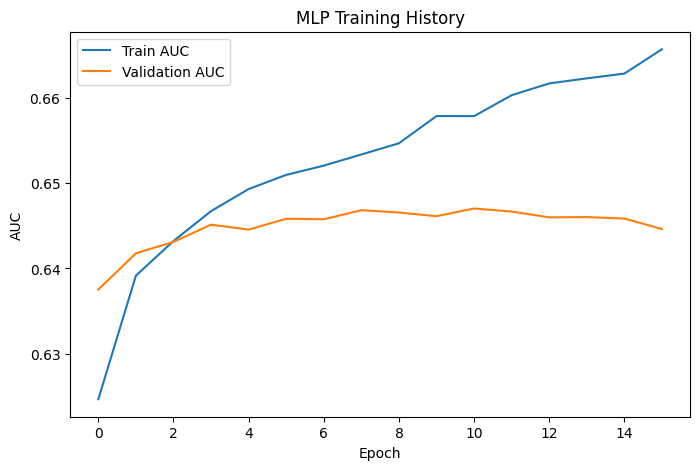

In [12]:
# Plot training history

plt.figure(figsize=(8,5))
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('MLP Training History')
plt.show()


### MLP Training History (AUC)

**What we’re plotting:** AUC on the **training** set vs the **validation** set across epochs.

**What we observe:**
- **Train AUC increases steadily** over epochs → the model is fitting the training data better and learning signal.
- **Validation AUC improves early and then plateaus** (stays almost flat) → generalization stops improving after a few epochs.
- The **gap between train and validation AUC grows slightly** → mild overfitting / diminishing returns from more training.

**How we use this:**
- **EarlyStopping (monitor = `val_auc`)** should select the best epoch around where validation AUC peaks/levels off.
- Next iterations should focus on **generalization** (e.g., smaller network, more regularization, tuning learning rate/batch size, or trying embeddings for categoricals) rather than training longer.

In [13]:
#-- Evaluate on test set ----
y_test_pred_prob = mlp.predict(X_test_nn).ravel()

# Default threshold (can be tuned later)
threshold = 0.5
y_test_pred = (y_test_pred_prob >= threshold).astype(int)

# Threshold choice affects precision/recall trade-off

# In credit risk, threshold tuning is critical (we’ll revisit this)

1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step


In [14]:
#Compute metrics
auc = roc_auc_score(y_test, y_test_pred_prob)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"AUC-ROC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


AUC-ROC: 0.6506
Precision: 0.2908
Recall: 0.6689
F1-score: 0.4054


### Test-set Results (Baseline MLP)

- **AUC-ROC = 0.6506** → the model has **moderate** ranking ability (better than random = 0.5), but not strong.
- At the default **threshold = 0.50**:
  - **Recall = 0.6689** → we catch ~67% of actual defaulters (good sensitivity).
  - **Precision = 0.2908** → only ~29% of predicted defaulters actually default (many false positives, expected with class imbalance).
  - **F1 = 0.4054** → reflects the precision–recall trade-off at this fixed threshold.

**Interpretation:** the model is reasonably good at **ranking** risk (AUC), but the chosen threshold yields **high recall / low precision**. Next step is to **tune the decision threshold** (and/or optimize for PR-AUC / cost-based metrics) depending on the business objective.

Threshold Tuning & ROC Analysis (Credit Risk Perspective)

Objective:
In credit risk, the classification threshold determines the trade-off between identifying defaults (recall) and avoiding false alarms (precision). We therefore analyze ROC curves and tune the threshold explicitly instead of relying on the default 0.5 cutoff.

### 10️ ROC Curve Analysis

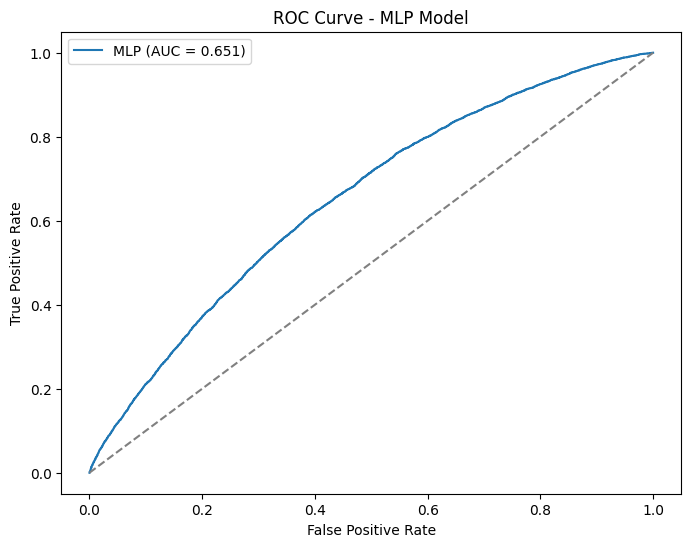

In [15]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"MLP (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP Model")
plt.legend()
plt.show()

ROC curve shows performance across all thresholds

In credit risk, ranking quality (AUC) matters more than accuracy

Helps justify threshold choice in business terms

In [16]:
thresholds

array([           inf, 9.52546597e-01, 9.44599807e-01, ...,
       5.26260473e-02, 5.17872758e-02, 1.53444603e-06], shape=(11323,))

1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step
Best threshold (val, max-F1): 0.4800
Validation F1 at best threshold: 0.4042
Validation Precision: 0.2812
Validation Recall:    0.7179


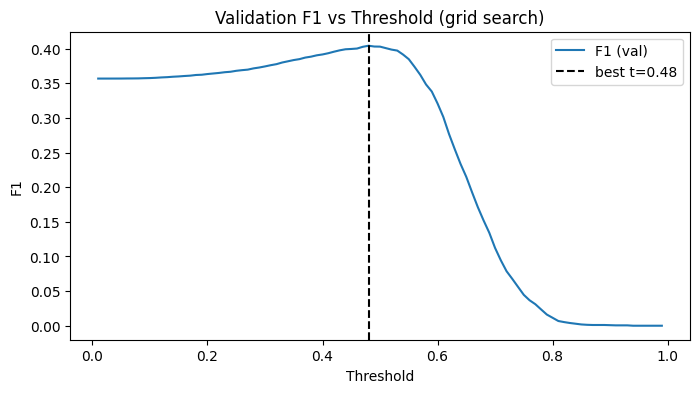

In [17]:
# ---- Threshold tuning (VALIDATION set; objective = maximize F1) ----

# 1) get validation probabilities (tune here, NOT on test)
y_val_prob = mlp.predict(X_val_nn).ravel()

# 2) define a small threshold grid (fast + stable for comparisons)
threshold_grid = np.linspace(0.01, 0.99, 99)

# 3) compute F1 per threshold on VALIDATION
f1_scores = []
for t in threshold_grid:
    y_val_hat = (y_val_prob >= t).astype(int)
    f1_scores.append(f1_score(y_val, y_val_hat, zero_division=0))

best_t = float(threshold_grid[int(np.argmax(f1_scores))])
best_f1_val = float(np.max(f1_scores))

print(f"Best threshold (val, max-F1): {best_t:.4f}")
print(f"Validation F1 at best threshold: {best_f1_val:.4f}")

# Optional: also show precision/recall at best threshold (interpretability)
y_val_hat_best = (y_val_prob >= best_t).astype(int)
print(f"Validation Precision: {precision_score(y_val, y_val_hat_best, zero_division=0):.4f}")
print(f"Validation Recall:    {recall_score(y_val, y_val_hat_best, zero_division=0):.4f}")

# Optional plot (lightweight)
plt.figure(figsize=(8, 4))
plt.plot(threshold_grid, f1_scores, label="F1 (val)")
plt.axvline(best_t, color="black", linestyle="--", label=f"best t={best_t:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("Validation F1 vs Threshold (grid search)")
plt.legend()
plt.show()

In [18]:
# ---- Evaluate on TEST using tuned threshold (reporting only) ----


y_test_prob = mlp.predict(X_test_nn).ravel()
y_test_hat = (y_test_prob >= best_t).astype(int)

auc_test = roc_auc_score(y_test, y_test_prob)
prec_test = precision_score(y_test, y_test_hat, zero_division=0)
rec_test = recall_score(y_test, y_test_hat, zero_division=0)
f1_test = f1_score(y_test, y_test_hat, zero_division=0)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_hat, labels=[0, 1]).ravel()

print(f"Test AUC (threshold-independent): {auc_test:.4f}")
print(f"Using tuned threshold = {best_t:.4f}")
print(f"Test Precision: {prec_test:.4f}")
print(f"Test Recall:    {rec_test:.4f}")
print(f"Test F1:        {f1_test:.4f}")
print("Confusion matrix (tn, fp, fn, tp):", (tn, fp, fn, tp))

1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step
Test AUC (threshold-independent): 0.6506
Using tuned threshold = 0.4800
Test Precision: 0.2838
Test Recall:    0.7237
Test F1:        0.4077
Confusion matrix (tn, fp, fn, tp): (np.int64(13520), np.int64(13862), np.int64(2098), np.int64(5494))


### Test-set Results (MLP + F1-Optimized Threshold)

To enable a **fair comparison across models** in an imbalanced credit-risk setting (without assuming an explicit cost function), we select the **classification threshold on the validation set** by **maximizing the F1-score**. F1 provides a neutral operating point by balancing **precision** (avoiding excessive false positives) and **recall** (capturing true defaults).

**Test performance (using the validation-tuned threshold):**
- **AUC-ROC = 0.6506** (threshold-independent ranking quality; moderate discrimination)
- **Tuned threshold = 0.48**
- **Precision = 0.2838**
- **Recall = 0.7237**
- **F1 = 0.4077**
- **Confusion matrix (tn, fp, fn, tp) = (13520, 13862, 2098, 5494)**

**Interpretation:**
- The tuned threshold increases sensitivity to defaults (**higher recall**) while maintaining similar precision, leading to a **slightly improved F1** relative to the default 0.50 cutoff.
- AUC remains unchanged because it evaluates ranking over all thresholds.
- This threshold-tuning protocol (tune on **validation**, report once on **test**) avoids test-set leakage and keeps the evaluation consistent for comparing against boosting models.

### Improved MLP Architecture (deeper + BatchNorm + regularization) 


Trials: 32

Trial 1/32: units=(256, 128), dropout=0.1, l2=0.0001, lr=0.0003, bs=256

  best val_roc_auc: 0.647677 | best val_pr_auc: 0.334420

Trial 2/32: units=(256, 128), dropout=0.1, l2=0.0001, lr=0.0003, bs=512
  best val_roc_auc: 0.643979 | best val_pr_auc: 0.325058

Trial 3/32: units=(256, 128), dropout=0.1, l2=0.0001, lr=0.001, bs=256
  best val_roc_auc: 0.645547 | best val_pr_auc: 0.331230

Trial 4/32: units=(256, 128), dropout=0.1, l2=0.0001, lr=0.001, bs=512
  best val_roc_auc: 0.645435 | best val_pr_auc: 0.331502

Trial 5/32: units=(256, 128), dropout=0.1, l2=0.0005, lr=0.0003, bs=256
  best val_roc_auc: 0.644548 | best val_pr_auc: 0.327186

Trial 6/32: units=(256, 128), dropout=0.1, l2=0.0005, lr=0.0003, bs=512
  best val_roc_auc: 0.644181 | best val_pr_auc: 0.325292

Trial 7/32: units=(256, 128), dropout=0.1, l2=0.0005, lr=0.001, bs=256
  best val_roc_auc: 0.644668 | best val_pr_auc: 0.329364

Trial 8/32: units=(256, 128), dropout=0.1, l2=0.0005, lr=0.001, bs=512
  best va

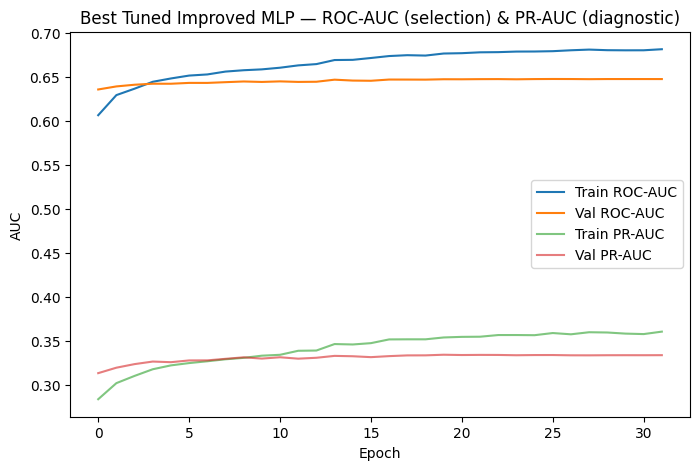

In [19]:
# ---- Improved MLP Architecture Hyperparameter Tuning (deeper + BatchNorm + regularization) ----
# Goal: improve representation capacity vs baseline MLP while controlling overfitting.
# What this does:
# 1) Trains many candidate MLP configurations on TRAIN (with class_weight for imbalance).
# 2) Selects the best model by highest VALIDATION AUC (threshold-independent).
# 3) Stores the winning model in `improved_mlp` so your existing evaluation code works unchanged.
#
# Why AUC for selection?
# - AUC measures ranking quality across all thresholds (stable for imbalanced data).
# - After selecting the model, you can still tune the classification threshold on VAL for F1/precision/recall.

import itertools

tf.keras.utils.set_random_seed(RANDOM_STATE)

n_features = X_train_nn.shape[1]

def build_mlp(n_features: int, units: tuple[int, ...], dropout: float, l2_strength: float, lr: float) -> tf.keras.Model:
    """
    Build an MLP for tabular binary classification.

    We track BOTH:
    - ROC-AUC (ranking quality)
    - PR-AUC  (more informative under class imbalance)
    """
    l2 = tf.keras.regularizers.l2(l2_strength)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(n_features,)))

    for u in units:
        model.add(tf.keras.layers.Dense(u, kernel_regularizer=l2))
        # NOTE: BatchNorm sometimes helps, sometimes hurts on tabular + one-hot.
        # Keep it for now; later we can try swapping to LayerNorm or removing BN.
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation("relu"))
        model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(name="roc_auc", curve="ROC"),
            tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
        ],
    )
    return model

# ---- Callbacks: early stop on ROC-AUC (stick to ROC-AUC) ----
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_roc_auc",
    mode="max",
    patience=6,
    restore_best_weights=True,
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_roc_auc",
    mode="max",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=0,
)

# ---- Bigger leverage knobs: learning rate + batch size ----
# Keep trials small so it runs fast on CPU.
# Hyperparameter grid for tuning:
# Each trial produced by itertools.product() returns a 5-tuple:
# (units, dropout, l2_strength, lr, batch_size)

grid = list(itertools.product(
    [(256, 128), (128, 64)],   # units: hidden-layer sizes (2-layer MLP); e.g., (256, 128)
    [0.10, 0.20],              # dropout: fraction of activations dropped after each layer (regularization)
    [1e-4, 5e-4],              # l2_strength: L2 weight decay applied to Dense layer kernels (regularization)
    [3e-4, 1e-3],              # lr: Adam learning rate
    [256, 512],                # batch_size: training batch size (speed/stability tradeoff)
))

# Optional: if this is too many, randomly sample ~20 configs:
# rng = np.random.default_rng(RANDOM_STATE)
# grid = [grid[i] for i in rng.choice(len(grid), size=20, replace=False)]

print("Trials:", len(grid))

# Select best model by VALIDATION ROC-AUC (threshold-independent)
best = {"val_roc_auc": -np.inf, "cfg": None, "model": None, "history": None}

for i, (units, dropout, l2_strength, lr, batch_size) in enumerate(grid, start=1):
    print(f"\nTrial {i}/{len(grid)}: units={units}, dropout={dropout}, l2={l2_strength}, lr={lr}, bs={batch_size}")

    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(RANDOM_STATE)

    candidate = build_mlp(
        n_features=n_features,
        units=units,
        dropout=dropout,
        l2_strength=l2_strength,
        lr=lr,
    )

    history_candidate = candidate.fit(
        X_train_nn, y_train,
        validation_data=(X_val_nn, y_val),
        epochs=40,
        batch_size=batch_size,
        class_weight=class_weight,
        callbacks=[early_stop, reduce_lr],
        verbose=0,
    )

    # Track both for diagnostics, but SELECT by ROC-AUC
    val_roc_auc_best = float(np.max(history_candidate.history["val_roc_auc"]))
    val_pr_auc_best  = float(np.max(history_candidate.history["val_pr_auc"]))
    print(f"  best val_roc_auc: {val_roc_auc_best:.6f} | best val_pr_auc: {val_pr_auc_best:.6f}")

    if val_roc_auc_best > best["val_roc_auc"]:
        best = {
            "val_roc_auc": val_roc_auc_best,
            "cfg": {"units": units, "dropout": dropout, "l2": l2_strength, "lr": lr, "batch_size": batch_size},
            "model": candidate,
            "history": history_candidate,
        }

print("\nBest VAL ROC-AUC:", best["val_roc_auc"])
print("Best config:", best["cfg"])

improved_mlp = best["model"]
best_cfg_improved = best["cfg"]

# Optional: plot best run (still OK to show both curves)
plt.figure(figsize=(8, 5))
plt.plot(best["history"].history["roc_auc"], label="Train ROC-AUC")
plt.plot(best["history"].history["val_roc_auc"], label="Val ROC-AUC")
plt.plot(best["history"].history["pr_auc"], label="Train PR-AUC", alpha=0.6)
plt.plot(best["history"].history["val_pr_auc"], label="Val PR-AUC", alpha=0.6)
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Best Tuned Improved MLP — ROC-AUC (selection) & PR-AUC (diagnostic)")
plt.legend()
plt.show()

In [20]:
# ---- Evaluate Improved MLP on TEST (default threshold = 0.50) ----
# Why: gives an apples-to-apples baseline operating point before any threshold tuning.

y_test_prob_improved = improved_mlp.predict(X_test_nn).ravel()

threshold_default = 0.50
y_test_hat_improved_default = (y_test_prob_improved >= threshold_default).astype(int)

auc_test_improved = roc_auc_score(y_test, y_test_prob_improved)
prec_test_improved_default = precision_score(y_test, y_test_hat_improved_default, zero_division=0)
rec_test_improved_default  = recall_score(y_test, y_test_hat_improved_default, zero_division=0)
f1_test_improved_default   = f1_score(y_test, y_test_hat_improved_default, zero_division=0)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_hat_improved_default, labels=[0, 1]).ravel()

print("Improved MLP — TEST (threshold=0.50)")
print(f"AUC:       {auc_test_improved:.4f}")  # threshold-independent
print(f"Precision: {prec_test_improved_default:.4f}")
print(f"Recall:    {rec_test_improved_default:.4f}")
print(f"F1:        {f1_test_improved_default:.4f}")
print("Confusion matrix (tn, fp, fn, tp):", (tn, fp, fn, tp))

1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step
Improved MLP — TEST (threshold=0.50)
AUC:       0.6486
Precision: 0.2940
Recall:    0.6270
F1:        0.4003
Confusion matrix (tn, fp, fn, tp): (np.int64(15954), np.int64(11428), np.int64(2832), np.int64(4760))


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Improved MLP — threshold tuning (VALIDATION)
Best threshold (max F1): 0.4500
Validation Precision:    0.2765
Validation Recall:       0.7525
Validation F1:           0.4044


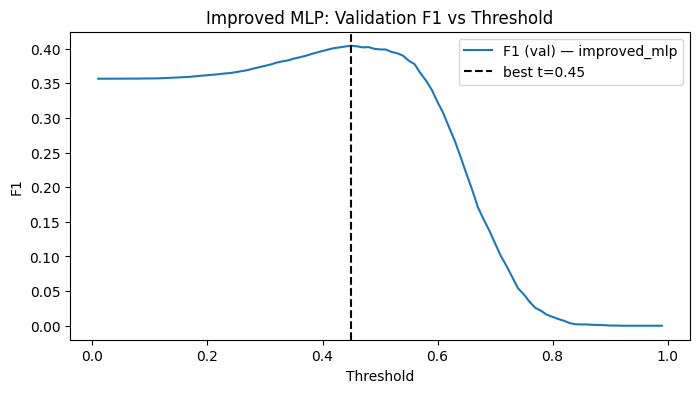

In [21]:
# ---- Threshold tuning for Improved MLP (VALIDATION set; objective = maximize F1) ----
# Why: choose the operating threshold without using test labels (avoid leakage).

y_val_prob_improved = improved_mlp.predict(X_val_nn).ravel()

threshold_grid = np.linspace(0.01, 0.99, 99)

f1_scores_improved = []
for t in threshold_grid:
    y_val_hat = (y_val_prob_improved >= t).astype(int)
    f1_scores_improved.append(f1_score(y_val, y_val_hat, zero_division=0))

best_t_improved = float(threshold_grid[int(np.argmax(f1_scores_improved))])
best_f1_val_improved = float(np.max(f1_scores_improved))

# Extra diagnostics at the chosen threshold (helps interpretation)
y_val_hat_best_improved = (y_val_prob_improved >= best_t_improved).astype(int)
prec_val_improved = precision_score(y_val, y_val_hat_best_improved, zero_division=0)
rec_val_improved  = recall_score(y_val, y_val_hat_best_improved, zero_division=0)

print("Improved MLP — threshold tuning (VALIDATION)")
print(f"Best threshold (max F1): {best_t_improved:.4f}")
print(f"Validation Precision:    {prec_val_improved:.4f}")
print(f"Validation Recall:       {rec_val_improved:.4f}")
print(f"Validation F1:           {best_f1_val_improved:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(threshold_grid, f1_scores_improved, label="F1 (val) — improved_mlp")
plt.axvline(best_t_improved, color="black", linestyle="--", label=f"best t={best_t_improved:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("Improved MLP: Validation F1 vs Threshold")
plt.legend()
plt.show()

In [22]:
# ---- Evaluate Improved MLP on TEST using tuned threshold (reporting only) ----
# Why: final unbiased test report after selecting threshold on validation.

y_test_hat_improved = (y_test_prob_improved >= best_t_improved).astype(int)

auc_test_improved = roc_auc_score(y_test, y_test_prob_improved)
prec_test_improved = precision_score(y_test, y_test_hat_improved, zero_division=0)
rec_test_improved  = recall_score(y_test, y_test_hat_improved, zero_division=0)
f1_test_improved   = f1_score(y_test, y_test_hat_improved, zero_division=0)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_hat_improved, labels=[0, 1]).ravel()

print("Improved MLP — TEST (tuned threshold from VAL)")
print(f"Test AUC (threshold-independent): {auc_test_improved:.4f}")
print(f"Using tuned threshold = {best_t_improved:.4f}")
print(f"Test Precision: {prec_test_improved:.4f}")
print(f"Test Recall:    {rec_test_improved:.4f}")
print(f"Test F1:        {f1_test_improved:.4f}")
print("Confusion matrix (tn, fp, fn, tp):", (tn, fp, fn, tp))

Improved MLP — TEST (tuned threshold from VAL)
Test AUC (threshold-independent): 0.6486
Using tuned threshold = 0.4500
Test Precision: 0.2781
Test Recall:    0.7586
Test F1:        0.4070
Confusion matrix (tn, fp, fn, tp): (np.int64(12436), np.int64(14946), np.int64(1833), np.int64(5759))


### Model comarison baseline vs improved MLP

In [23]:
# ---- compare Baseline MLP vs Improved MLP (TEST, tuned thresholds) ----

results_compare = pd.DataFrame([
    {"model": "baseline_mlp",  "auc": auc_test,        "threshold": best_t,          "precision": prec_test,         "recall": rec_test,         "f1": f1_test},
    {"model": "improved_mlp",  "auc": auc_test_improved, "threshold": best_t_improved, "precision": prec_test_improved, "recall": rec_test_improved, "f1": f1_test_improved},
])

display(results_compare)

,model,auc,threshold,precision,recall,f1
0,baseline_mlp,0.650593,0.48,0.283840,0.723656,0.407748
1,improved_mlp,0.648562,0.45,0.278145,0.758562,0.407040


- The **baseline slightly wins on ROC-AUC**, meaning it ranks borrowers marginally better overall.
- The **improved model achieves higher recall** at its tuned threshold (catches more defaulters) but at the cost of slightly lower precision, resulting in a **similar F1**.
- Overall, the architecture changes do **not** yield a clear generalization improvement; differences are small and could be within sampling variability. For stronger gains, we could focus on threshold policy (recall/precision constraints),more hyper parameter tuning and/or richer tabular modeling (embeddings for categoricals, calibrated probabilities, or boosting models).

### Exporting Predictions for Boosting Model Comparison

In [24]:
# ---- FINAL EXPORT: save models + prediction CSVs for 04_model_comparison.ipynb ----

# 1) Select "best NN" in a leakage-safe way (based on VAL AUC)
p_val_baseline = mlp.predict(X_val_nn).ravel()
p_val_improved = improved_mlp.predict(X_val_nn).ravel()

auc_val_baseline = float(roc_auc_score(y_val, p_val_baseline))
auc_val_improved = float(roc_auc_score(y_val, p_val_improved))

best_name = "improved_mlp" if auc_val_improved >= auc_val_baseline else "baseline_mlp"

print(f"VAL AUC baseline_mlp: {auc_val_baseline:.6f}")
print(f"VAL AUC improved_mlp: {auc_val_improved:.6f}")
print("Selected best NN (by VAL AUC):", best_name)

# 2) Save both trained models to ../models
# Recommended Keras format: .keras (portable + includes optimizer config if present)
baseline_model_path = os.path.join(MODELS_DIR, "baseline_mlp.keras")
improved_model_path = os.path.join(MODELS_DIR, "improved_mlp.keras")

mlp.save(baseline_model_path)
improved_mlp.save(improved_model_path)

print("Saved model:", baseline_model_path)
print("Saved model:", improved_model_path)

# 3) Export test predictions for BOTH models + a "best" file expected by 04_model_comparison.ipynb
p_test_baseline = mlp.predict(X_test_nn).ravel()
p_test_improved = improved_mlp.predict(X_test_nn).ravel()

baseline_path = os.path.join(RESULTS_DIR, "nn_baseline_test_preds.csv")
improved_path = os.path.join(RESULTS_DIR, "nn_improved_test_preds.csv")
best_path     = os.path.join(RESULTS_DIR, "nn_best_test_preds.csv")

pd.DataFrame({
    "UNIQUEID": id_test,
    "y_true": y_test.astype(int),
    "y_prob": p_test_baseline.astype(float),
}).to_csv(baseline_path, index=False)

pd.DataFrame({
    "UNIQUEID": id_test,
    "y_true": y_test.astype(int),
    "y_prob": p_test_improved.astype(float),
}).to_csv(improved_path, index=False)

p_best = p_test_improved if best_name == "improved_mlp" else p_test_baseline
pd.DataFrame({
    "UNIQUEID": id_test,
    "y_true": y_test.astype(int),
    "y_prob": p_best.astype(float),
}).to_csv(best_path, index=False)

print("Saved preds:", baseline_path)
print("Saved preds:", improved_path)
print("Saved preds:", best_path)


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step
VAL AUC baseline_mlp: 0.647033
VAL AUC improved_mlp: 0.647672
Selected best NN (by VAL AUC): improved_mlp
Saved model: ..\models\baseline_mlp.keras
Saved model: ..\models\improved_mlp.keras
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Saved preds: ..\results\nn_baseline_test_preds.csv
Saved preds: ..\results\nn_improved_test_preds.csv
Saved preds: ..\results\nn_best_test_preds.csv
